# Full OCRopus 4 Training and Running

This worksheet demonstrates OCRopus 4 training from start to finish, including bootstrapping using another OCR system.



Important Notes:

- this does NOT yield usable models since the training data set used in this worksheet is so small and limited
- this implements the main components of an OCR system and is suitable for text indexing and other applications, but full page recognition requires some additional components

In [1]:
import os
os.getcwd()
os.system("sos convert full.ipynb full.sos")

0

In [2]:
rm -f *.sqlite3 *.pth
rm -f book-seg.tar book-words.tar book-lines.tar

In [3]:
[global]
display = 10
maxpages = 50; multiplier = 1
# maxpages = 9999; multiplier = 1000
maxextract = 1000 * multiplier
nwordtrain = 1000 * multiplier
nsegtrain = 200 * multiplier
nrottrain = 200 * multiplier
nskewtrain = 200 * multiplier
nscaletrain = 200 * multiplier
nbintrain = 10 * multiplier
dataurl = 'http://storage.googleapis.com/ocropus4/Volume_0000.tar'

# Download Dataset and Run Tesseract

The dataset is Volume 0 from Google's 1000 Book dataset. These images are camera scanned, modest resolution, modest quality images. This volume contains a mix of English and Gaelic.

_This dataset is used here for demonstration purposes only. It is not large or diverse enough to train a practical recognizer. You can obtain a usable recognizer by training on the UW3 dataset, but unfortunately that's not redistributable. We are currently putting together a larger, representative training set._

We use Tesseract as our bootstrap OCR system.

In [4]:
[download]
input: []
output: 'Volume_0000.tar'
sh: expand=True
    curl {dataurl} > Volume_0000.tar

In [5]:
%sosrun download

INFO: Running download :

INFO: download (index=0) is ignored due to saved signature

INFO: download output: Volume_0000.tar

INFO: Workflow download (ID=w7ea7cd24b3622f7d) is ignored with 1 ignored step.

## Binarization

By default, we binarize with a hardcoded binarizer based on grayscale morphology. This binarizer is purely CPU based (we may eventually port it to the GPU). It has worked very well in many different settings. 

In [6]:
tarp cat --help

[info] version 2021-03-04T11:06:08-08:00 false
Usage:
  tarp [OPTIONS] cat [cat-OPTIONS] [Inputs...]

Application Options:
  -v                    verbose output

Help Options:
  -h, --help            Show this help message

[cat command options]
      -f, --field=      fields to extract
      -o, --outputs=    output file
      -s, --shuffle=    shuffle samples in memory (default: 0)
      -E, --noeof       don't send/receive EOF for ZMQ
      -L, --logging=    log this often (default: 0)
      -m, --mix=        mix samples from multiple sources (default: 0)
      -l, --load        load file list
          --maxerr=     maximum number of errors (default: 0)
          --shardslice= select samples from each input
          --slice=      select samples (lo:hi:step)
      -R, --rekey=      replace the key based on spec (--rekey='#')



In [7]:
[binarize]
input: 'Volume_0000.tar'
output: 'raw.tar'
sh: expand=True
    vocropus nlbin binarize {_input} --gray --output raw.tar --maxrec {maxpages}

In [8]:
%sosrun binarize

INFO: Running binarize :

INFO: binarize (index=0) is ignored due to saved signature

INFO: binarize output: raw.tar

INFO: Workflow binarize (ID=w0d894c5479ef03b2) is ignored with 1 ignored step.

## Bootstrap OCR Recognizer

We're using Tesseract as the bootstrap OCR engine. Tesseract runs on the normalized images returned in the previous step. The bootstrap OCR recognizer can have a moderately high error rate and OCRopus 4 can still be trained on it successfully. In fact, once you have trained an initial OCRopus 4 recognizer, you can use it as the bootstrap recognizer for additional source materials. OCRopus 4 is, in effect, self-training and self-improving.

In [9]:
!rebuild=y ./dtess --help

Sending build context to Docker daemon  2.048kB
Step 1/5 : FROM ubuntu:20.04
 ---> f643c72bc252
Step 2/5 : RUN date
 ---> Using cache
 ---> 5331dfc33a69
Step 3/5 : RUN apt-get update && apt-get install -y tesseract-ocr-all
 ---> Using cache
 ---> 3c9154853045
Step 4/5 : RUN mkdir /work
 ---> Using cache
 ---> d848a1aab5f4
Step 5/5 : WORKDIR /work
 ---> Using cache
 ---> e2f85069c280
Successfully built e2f85069c280
Successfully tagged tess:latest
Usage:
  tesseract --help | --help-extra | --version
  tesseract --list-langs
  tesseract imagename outputbase [options...] [configfile...]

OCR options:
  -l LANG[+LANG]        Specify language(s) used for OCR.
NOTE: These options must occur before any configfile.

Single options:
  --help                Show this help message.
  --help-extra          Show extra help for advanced users.
  --version             Show version information.
  --list-langs          List available languages for tesseract engine.


In [10]:
[tess]
input: 'raw.tar'
output: 'tess.tar'
sh: expand=True
    rebuild=y dtess --help
    tarp proc -c $(pwd)/'dtess sample.nrm.jpg sample.tess -l eng hocr; rm -f sample.lines.png sample.pseg.png' {_input} -o {_output}.tar.temp
    mv {_output}.tar.temp {_output}

In [11]:
%sosrun tess

INFO: Running tess :

INFO: tess (index=0) is ignored due to saved signature

INFO: tess output: tess.tar

INFO: Workflow tess (ID=wb048cdb2f1711e24) is ignored with 1 ignored step.

# Generating Training Datasets

OCRopus 4 training starts with tar files containing pairs of images and corresponding hOCR output. These are used to generate training data for word and line recognition and page segmentation.

In [12]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [13]:
figsize(12, 8)
import webdataset as wds
from itertools import islice

In [14]:
ds = wds.WebDataset("tess.tar").decode("rgb8")
sample = next(islice(ds, 33, 999))
print(sample.keys())
print(sample["tess.hocr"].decode("utf-8"))

dict_keys(['__key__', 'jpg', 'nrm.jpg', 'tess.hocr'])
<?xml version="1.0" encoding="UTF-8"?>
<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN"
    "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">
<html xmlns="http://www.w3.org/1999/xhtml" xml:lang="en" lang="en">
 <head>
  <title></title>
  <meta http-equiv="Content-Type" content="text/html;charset=utf-8"/>
  <meta name='ocr-system' content='tesseract 4.1.1' />
  <meta name='ocr-capabilities' content='ocr_page ocr_carea ocr_par ocr_line ocrx_word ocrp_wconf'/>
 </head>
 <body>
  <div class='ocr_page' id='page_1' title='image "sample.nrm.jpg"; bbox 0 0 1507 2131; ppageno 0'>
   <div class='ocr_carea' id='block_1_1' title="bbox 8 284 22 743">
    <p class='ocr_par' id='par_1_1' lang='eng' title="bbox 8 284 22 743">
     <span class='ocr_line' id='line_1_1' title="bbox 8 284 22 743; textangle 90; x_size 22.75; x_descenders 5.5; x_ascenders 5.75">
      <span class='ocrx_word' id='word_1_1' title='bbox 8 284 22 700; 

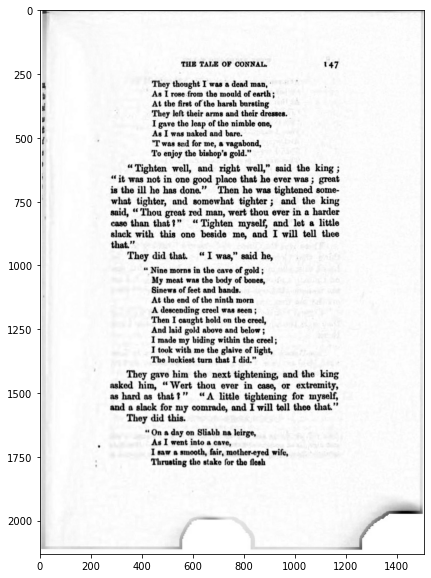

In [15]:
figsize(15, 10)
imshow(sample["nrm.jpg"])

## Segmentation Data

Segmentation algorithms are usually trained on four-label segmentation targets consisting of markers, areas, separators, and background. The `extract-seg hocr2seg` subcommand extracts those training images.

Ordinarily, we would extract this data from many shards and shuffle it for training, but we're dispensing with that in this simple example.


In [16]:
[seg-data]
input: 'tess.tar'
output: 'book-seg.tar'
sh: expand=True
    export MPLBACKEND=TkAgg
    vocropus extract-seg hocr2seg {_input} --output {_output}.temp --element ocrx_word --extensions 'nrm.jpg tess.hocr' --invert True \
        --show 100 --labels='1, 2, 3' --check word --maxcount {maxextract}
    mv {_output}.temp {_output}


In [17]:
%sosrun seg-data

INFO: Running seg-data :

# Volume_0000/pg0194 count 0 maxcount 1000
# 39 bad bboxes, 0 no confidence, 417 good, 20 bad text, 517 total
# interesting patches 50
0
# 39 bad bboxes, 0 no confidence, 417 good, 20 bad text, 517 total
# interesting patches 50
# 39 bad bboxes, 0 no confidence, 417 good, 20 bad text, 517 total
# interesting patches 50
# Volume_0000/pg0439 count 150 maxcount 1000
# 2 bad bboxes, 0 no confidence, 325 good, 14 bad text, 387 total
# interesting patches 50
# 2 bad bboxes, 0 no confidence, 325 good, 14 bad text, 387 total
# interesting patches 50
# 2 bad bboxes, 0 no confidence, 325 good, 14 bad text, 387 total
# interesting patches 50
# Volume_0000/pg0011 count 300 maxcount 1000
# too many bad bounding boxes on this page
didn't get any ocrx_word
# too many bad bounding boxes on this page
didn't get any ocrx_word
# too many bad bounding boxes on this page
didn't get any ocrx_word
# Volume_0000/pg0205 count 300 maxcount 1000
# 6 bad bboxes, 0 no confidence, 452 good, 4 bad text, 484 total
# 

INFO: seg-data output: book-seg.tar

INFO: Workflow seg-data (ID=w359f8a17bb12b8f1) is executed successfully with 1 completed step.

dict_keys(['__key__', 'png', 'seg.png'])


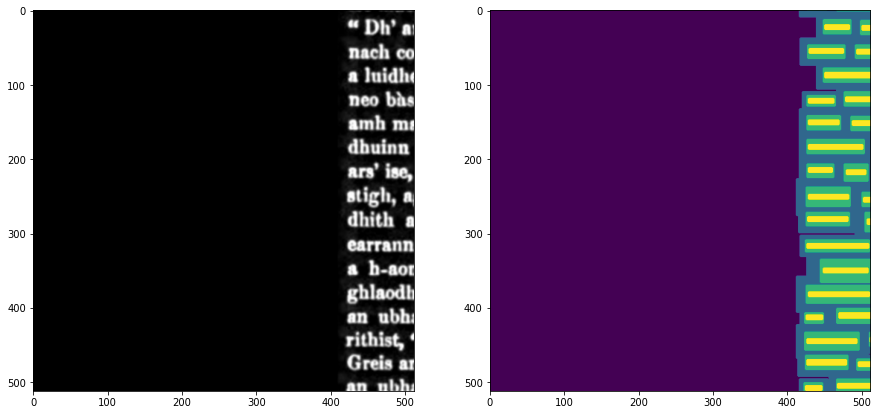

In [18]:
ds = wds.WebDataset("book-seg.tar").decode("rgb")
sample= next(islice(iter(ds), 5, 999))
print(sample.keys())
subplot(121); imshow(sample["png"])
subplot(122); imshow(sample["seg.png"][...,2])

## Word Training Data

As before, we use `extract-rec hocr2rec` to extract word training images.

In [19]:
[word-data]
input: 'tess.tar'
output: 'book-words.tar'
sh: expand=True
    vocropus extract-rec hocr2rec {_input} --output {_output}.temp --element ocrx_word --extensions 'nrm.jpg tess.hocr' \
        --bounds 10,10,500,100 --dictionary /usr/share/dict/american-english-huge --maxcount {maxextract} \
        --acceptable-conf 60.0
    mv {_output}.temp {_output}

In [20]:
%sosrun word-data

INFO: Running word-data :

reading /usr/share/dict/american-english-huge
# got 517 elements of class ocrx_word
# bad text CATH
0
# bad text EUN.
# bad text 43
# bad text thdisich
# bad text damhsa,
# acceptable_size((542, 255, 571, 289)) is False
# confidence 46.0 < acceptable confidence 60.0
# bad text Bha
# bad text tigh
# bad text fhamhair
# bad text chrith
# bad text bho
# bad text ’mhullach
# confidence 37.0 < acceptable confidence 60.0
# confidence 18.0 < acceptable confidence 60.0
# bad text Ach
# confidence 2.0 < acceptable confidence 60.0
# bad text dol
# acceptable_size((1023, 297, 1047, 324)) is False
# bad text luidhe,
# acceptable_size((1157, 291, 1187, 324)) is False
# bad text thubhairt
# bad text famhair,
# bad text “Tha
# acceptable_size((665, 325, 697, 359)) is False
# bad text t-am
# confidence 58.0 < acceptable confidence 60.0
# bad text dol
# acceptable_size((899, 332, 925, 359)) is False
# bad text luidhe,
# acceptable_size((1021, 332, 1047, 359)) is False
# bad text mhic
# bad text ngh
# b

INFO: word-data output: book-words.tar

INFO: Workflow word-data (ID=w31ffbe5a889fac72) is executed successfully with 1 completed step.

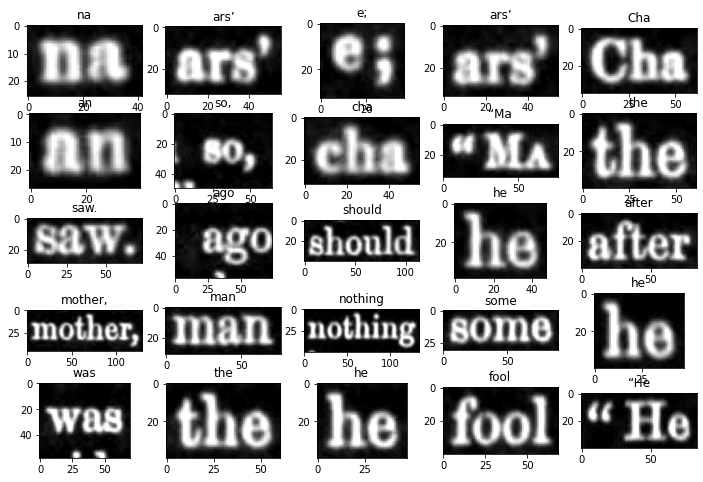

In [21]:
figsize(12, 8)
import webdataset as wds
from itertools import islice
ds = wds.WebDataset("book-words.tar").decode("rgb")
start = 55
for i, sample in enumerate(islice(iter(ds), start, start+250, 10)):
    subplot(5, 5, i+1)
    imshow(sample["png"])
    title(sample["txt"])

## Detecting Character Outliers

We need to decide on a character training set. Here is some optional code that goes through all training strings and identifies rare and unusual characters.

You can use the output from this optional step either to transform the text strings in the training data, or to add new character set classes to OCRopus 4.

In [22]:
[detect-outliers]
input: 'book-words.tar'
output: 'bad-chars.txt'

python:

    ds = wds.WebDataset("book-words.tar").decode("rgb")
    alltext = [sample["txt"] for sample in ds]

    from collections import Counter
    counter = Counter()
    for s in alltext: counter.update(s)

    for c, n in counter.most_common():
        if len(str(c.encode("unicode_escape"))) > 4:
            print(f"""{c} {str(c.encode("unicode_escape")):10s} {n:10d}""")

# Training a Word Segmenter

This is the training script for word segmentation. It's pretty straightforward and just uses the `book-seg.tar` data generated previously.

All training jobs log to Sqlite3 databases and also save their models into those databases. You can use the `ocropus4 slog` subcommand to extract the best or the last model and plot training curves.

In [23]:
[train-segs]
input: 'book-seg.tar'
output: 'segtrain.pth'
sh: expand=True
    export MPLBACKEND=TkAgg
    vocropus ocroseg train {_input} --log-to segtrain.sqlite3 --ntrain {nsegtrain} --display {display}
    vocropus slog getlast segtrain.sqlite3 --output {_output}

In [24]:
%sosrun train-segs

INFO: Running train-segs :

No LSB modules are available.
No LSB modules are available.
Sequential(
  (0): GrayDocument(noise=0.0, autoinvert=True)
  (1): Input(BDHW->BDHW torch.float32 (0, 1) cuda:0 [None, 1, None, None])
  (2): InputStats(segmodel)
  (3): ModPad(8)
  (4): UnetLayer(
    (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (up): ConvTranspose2d(128, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (sub): UnetLayer(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (down): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (up): ConvTranspose2d(192, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (sub): UnetLayer(
        (conv): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (down): MaxPool2d(kernel_size=2, stride=2, padding=0,

INFO: train-segs output: segtrain.pth

INFO: Workflow train-segs (ID=wd23f2140b8c1ea88) is executed successfully with 1 completed step.

# Training a Word Recognizer

To train a word recognizer, we use the `ocrorec train` command using the `book-words.tar` dataset.

In [25]:
[train-words]
input: 'book-words.tar'
output: 'wordtrain.pth'
sh: expand=True
    export MPLBACKEND=TkAgg
    vocropus ocrorec train {_input} --log-to wordtrain.sqlite3 --ntrain {nwordtrain} --display {display}
    vocropus slog getlast wordtrain.sqlite3 --output {_output}

In [26]:
%sosrun train-words

INFO: Running train-words :

No LSB modules are available.
No LSB modules are available.
1000
torch.Size([3, 1, 50, 85])
Sequential(
  (0): GrayDocument(noise=0.0, autoinvert=True)
  (1): Input(BDHW->BDHW torch.float32 (0, 1) cuda:0 [None, 1, None, None])
  (2): InputStats(textmodel)
  (3): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU()
  (13): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (14): BatchNorm2d(48, eps=1e-05, momentum=0.1, affin

INFO: train-words output: wordtrain.pth

INFO: Workflow train-words (ID=w0ec70ebde84e35a8) is executed successfully with 1 completed step.

# Line Segmentation

The base recognizer recognizes individual words; these need to be grouped into text lines as part of the recognition process. We train a separate text line segmentation model for this. The procedure is the same as for word segmentation: we generate line segmentation images for training and then use the `ocroseg train` command to train a segmenter.

In [27]:
[line-data]
input: 'tess.tar'
output: 'book-lines.tar'
sh: expand=True
    export MPLBACKEND=TkAgg
    vocropus extract-seg hocr2seg {_input} --output {_output}.temp --element ocr_line --extensions 'nrm.jpg tess.hocr' --invert True \
        --show 100 --labels='1, 2, 3' --check line --maxcount {maxextract}
    mv {_output}.temp {_output}


In [28]:
%sosrun line-data

INFO: Running line-data :

# Volume_0000/pg0194 count 0 maxcount 1000
# 0 bad bboxes, 42 no confidence, 42 good, 1 bad text, 43 total
# interesting patches 50
0
# 0 bad bboxes, 42 no confidence, 42 good, 1 bad text, 43 total
# interesting patches 50
# 0 bad bboxes, 42 no confidence, 42 good, 1 bad text, 43 total
# interesting patches 50
# Volume_0000/pg0439 count 150 maxcount 1000
# 0 bad bboxes, 36 no confidence, 36 good, 0 bad text, 36 total
# interesting patches 50
# 0 bad bboxes, 36 no confidence, 36 good, 0 bad text, 36 total
# interesting patches 50
# 0 bad bboxes, 36 no confidence, 36 good, 0 bad text, 36 total
# interesting patches 50
# Volume_0000/pg0011 count 300 maxcount 1000
# too many bad bounding boxes on this page
didn't get any ocr_line
# too many bad bounding boxes on this page
didn't get any ocr_line
# too many bad bounding boxes on this page
didn't get any ocr_line
# Volume_0000/pg0205 count 300 maxcount 1000
# 0 bad bboxes, 40 no confidence, 40 good, 0 bad text, 40 total
# interesting patches

INFO: line-data output: book-lines.tar

INFO: Workflow line-data (ID=wd490dec2aefdafc9) is executed successfully with 1 completed step.

dict_keys(['__key__', 'png', 'seg.png'])


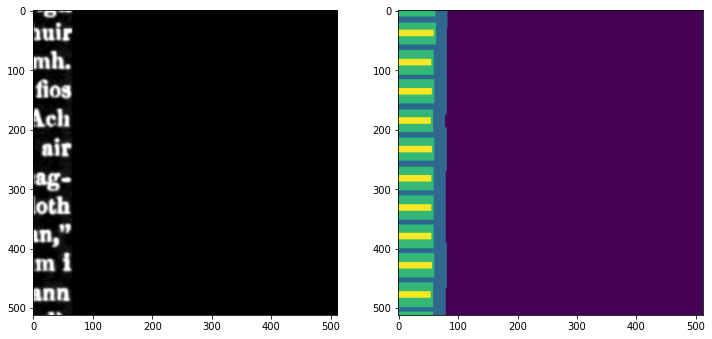

In [29]:
ds = wds.WebDataset("book-lines.tar").decode("rgb")
sample= next(islice(iter(ds), 100, 999))
print(sample.keys())
subplot(121); imshow(sample["png"])
subplot(122); imshow(sample["seg.png"][...,2])

In [30]:
[train-lines]
input: 'book-lines.tar'
output: 'linetrain.pth'
sh: expand=True
    export MPLBACKEND=TkAgg
    vocropus ocroseg train {_input} --log-to linetrain.sqlite3 --ntrain {nsegtrain} --display {display}
    rm -f {_output}
    vocropus slog getlast linetrain.sqlite3 --output {_output}

In [31]:
%sosrun train-lines

INFO: Running train-lines :

No LSB modules are available.
No LSB modules are available.
Sequential(
  (0): GrayDocument(noise=0.0, autoinvert=True)
  (1): Input(BDHW->BDHW torch.float32 (0, 1) cuda:0 [None, 1, None, None])
  (2): InputStats(segmodel)
  (3): ModPad(8)
  (4): UnetLayer(
    (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (up): ConvTranspose2d(128, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (sub): UnetLayer(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (down): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (up): ConvTranspose2d(192, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (sub): UnetLayer(
        (conv): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (down): MaxPool2d(kernel_size=2, stride=2, padding=0,

INFO: train-lines output: linetrain.pth

INFO: Workflow train-lines (ID=w953bac738ad8d9d5) is executed successfully with 1 completed step.

# Running the Page Recognizer

The page reocgnizer consists of several steps:

- word segmentation: segment the input page into individual words
- word recognition: apply the word recognizer to the word segments
- line segmentation: apply the line segmenter to obtain text line seeds
- grouping: use the line segmentation output to group word boxes into text line
- sorting: text lines are finally sorted in a simple way to obtain the final output

Output is both in .tar format and as a single .html file in hOCR format (the hOCR is not compliant yet).

The final sort currently uses simple heuristics; eventually, there will be a second grouping step based on text block training.

In [32]:
[page-recognition]
input: 'tess.tar'
output: 'recognized.tar'
sh: expand=True
    export MPLBACKEND=TkAgg
    vocropus pagerec recognize {_input} --output {_output} --recmodel wordtrain.pth --segmodel segtrain.pth --lgmodel linetrain.pth --full-html recognized.html --extensions nrm.jpg --maxrec 10

In [33]:
%sosrun page-recognition

INFO: Running page-recognition :

INFO: page-recognition (index=0) is ignored due to saved signature

INFO: page-recognition output: recognized.tar

INFO: Workflow page-recognition (ID=wc440f69b72d91dff) is ignored with 1 ignored step.

Here are some recognition results; these are NOT representative of what is achievable with OCRopus 4, since they are recognition results obtained on a tiny training data set with limited training data. Given this very limited training, recognition performance is actually pretty good.

In [34]:
!lynx -dump recognized.html | tail -30

Volume_0000/pg0194

Volume_0000/pg0439

Volume_0000/pg0011

Volume_0000/pg0205

Volume_0000/pg0113

Volume_0000/pg0018

Volume_0000/pg0351

Volume_0000/pg0021

Volume_0000/pg0410

Volume_0000/pg0079


# Page Orientation

Before any kind of document processing, it is a good idea to ensure that pages are right side up. The `ocrorot` command handles this. We can first train a page orientation model and then apply it to correct the orientation of pages. Training just requires a collection of pages in right-side-up orientation as input.

In [35]:
[train-rot]
input: 'tess.tar'
output: 'rottrain.pth'
sh: expand=True
    export MPLBACKEND=TkAgg
    base=$(basename {_output} .pth)
    rm -f $base.sqlite3
    vocropus ocrorot train {_input} --display 15 --output $base.sqlite3 --nsamples {nrottrain} --replicate 8 --num-workers 8 --extensions nrm.jpg
    vocropus slog getbest $base.sqlite3 --output {_output}

In [36]:
%sosrun train-rot

INFO: Running train-rot :

No LSB modules are available.
No LSB modules are available.
Sequential(
  (0): CheckSizes((2, 128), (1, 512), (256, 256), (256, 256))
  (1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Conv2

INFO: train-rot output: rottrain.pth

INFO: Workflow train-rot (ID=w2366b8da658a9b3b) is executed successfully with 1 completed step.

In [37]:
[predict-rot]
input: 'rottrain.pth'
sh: expand=True
    vocropus ocrorot correct tess.tar --nsamples 10 --model rottrain.pth

In [38]:
%sosrun predict-rot

INFO: Running predict-rot :

Volume_0000/pg0194 (2115, 1522) 0
Volume_0000/pg0439 (2108, 1572) 0
Volume_0000/pg0011 (2108, 1518) 0
Volume_0000/pg0205 (2115, 1522) 0
Volume_0000/pg0113 (2118, 1504) 0
Volume_0000/pg0018 (2108, 1518) 0
Volume_0000/pg0351 (2132, 1519) 0
Volume_0000/pg0021 (2108, 1518) 0
Volume_0000/pg0410 (2132, 1519) 0
Volume_0000/pg0079 (2118, 1504) 0


INFO: Workflow predict-rot (ID=w294989719c37cbe8) is executed successfully with 1 completed step.

# Page Skew Correction

"Page skew" refers to small rotations of scanned pages--small deviations from the vertical. The `ocroskew` command can be used to train page skew models and perform page skew correction. These models are generally trained and applied after page orientation correction. Training just requires a collection of already deskewed images as input.

In [39]:
[train-skew]
input: 'tess.tar'
output: 'skewtrain.pth'
sh: expand=True
    export MPLBACKEND=TkAgg
    base=$(basename {_output} .pth)
    rm -f $base.sqlite3
    vocropus ocroskew train {_input} --display 15 --output $base.sqlite3 --nsamples {nskewtrain} --replicate 8 --num-workers 8 --extensions 'nrm.jpg'
    vocropus slog getbest $base.sqlite3 --output {_output}

In [40]:
%sosrun train-skew

INFO: Running train-skew :

No LSB modules are available.
No LSB modules are available.
Sequential(
  (0): GrayDocument(noise=0.0, autoinvert=True)
  (1): Input(BDHW->BDHW torch.float32 (0, 1) cuda:0 [None, 1, None, None])
  (2): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): ReLU()
  (5): Spectrum-logplus1
  (6): Conv2d(8, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (7): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): Reshape(0, [1, 2, 3])
  (10): Linear(in_features=262144, out_features=210, bias=True)
  (11): BatchNorm1d(210, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU()
  (13): Linear(in_features=210, out_features=21, bias=True)
)
64 3.0450122356414795 0.90625 0.026999999999999996

saved at 256
saving step 256.0 scalar 2.993287205696106


INFO: train-skew output: skewtrain.pth

INFO: Workflow train-skew (ID=w654195ad78f32e25) is executed successfully with 1 completed step.

In [41]:
[predict-skew]
input: 'skewtrain.pth'
sh: expand=True
    vocropus ocroskew correct tess.tar --nsamples 10 --model skewtrain.pth

In [42]:
%sosrun predict-skew

INFO: Running predict-skew :

Volume_0000/pg0194 (2115, 1522) -0.09000000000000001
Volume_0000/pg0439 (2108, 1572) -0.09000000000000001
Volume_0000/pg0011 (2108, 1518) -0.09000000000000001
Volume_0000/pg0205 (2115, 1522) -0.09000000000000001
Volume_0000/pg0113 (2118, 1504) -0.09000000000000001
Volume_0000/pg0018 (2108, 1518) -0.09000000000000001
Volume_0000/pg0351 (2132, 1519) -0.09000000000000001
Volume_0000/pg0021 (2108, 1518) -0.09000000000000001
Volume_0000/pg0410 (2132, 1519) -0.09000000000000001
Volume_0000/pg0079 (2118, 1504) -0.09000000000000001


INFO: Workflow predict-skew (ID=w9ec4016d5cc1fec2) is executed successfully with 1 completed step.

# Page Scale Analysis

Document layout analysis, and to a lesser degree text recognition, assumes that documents are presented at a fairly consistent image resolution (usually 300 dpi). The `ocroscale` command can be trained on a collection of documents at the desired target resolution (e.g., 300 dpi) and when applied to novel documents, will estimate the document scale relative to the training collection. No other ground truth is necessary.

The `ocroscale` command has the option for page-by-page "scale correction", though for bulk processing, it is better to estimate the scale factor for a new batch of documents once and then rescale the entire document batch with a consistent scale.

In [43]:
[train-scale]
input: 'tess.tar'
output: 'scaletrain.pth'
sh: expand=True
    export MPLBACKEND=TkAgg
    base=$(basename {_output} .pth)
    rm -f $base.sqlite3
    vocropus ocroscale train {_input} --display 15 --output $base.sqlite3 --nsamples {nscaletrain} --replicate 8 --num-workers 8
    vocropus slog getbest $base.sqlite3 --output {_output}

In [44]:
%sosrun train-scale

INFO: Running train-scale :

No LSB modules are available.
No LSB modules are available.
Sequential(
  (0): GrayDocument(noise=0.0, autoinvert=True)
  (1): Input(BDHW->BDHW torch.float32 (0, 1) cuda:0 [None, 1, None, None])
  (2): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): ReLU()
  (5): Spectrum-logplus1
  (6): Conv2d(8, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (7): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): Reshape(0, [1, 2, 3])
  (10): Linear(in_features=480000, out_features=110, bias=True)
  (11): BatchNorm1d(110, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU()
  (13): Linear(in_features=110, out_features=11, bias=True)
)
16 2.515294313430786 0.9375 0.026999999999999996

saved at 208
saving step 208.0 scalar 2.0083518486756544


INFO: train-scale output: scaletrain.pth

INFO: Workflow train-scale (ID=we84988c3be8fbc1d) is executed successfully with 1 completed step.

In [45]:
[predict-scale]
input: 'scaletrain.pth'
sh: expand=True
    vocropus ocroscale hist tess.tar --nsamples 10 --model scaletrain.pth

In [46]:
%sosrun predict-scale

INFO: Running predict-scale :

Volume_0000/pg0194 (2115, 1522) 2.38
Volume_0000/pg0439 (2108, 1572) 2.38
Volume_0000/pg0011 (2108, 1518) 2.38
Volume_0000/pg0205 (2115, 1522) 2.38
Volume_0000/pg0113 (2118, 1504) 2.38
Volume_0000/pg0018 (2108, 1518) 2.38
Volume_0000/pg0351 (2132, 1519) 2.38
Volume_0000/pg0021 (2108, 1518) 2.38
Volume_0000/pg0410 (2132, 1519) 2.38
Volume_0000/pg0079 (2118, 1504) 2.38
2.382984704172845


INFO: Workflow predict-scale (ID=wfef4ae324c3f1274) is executed successfully with 1 completed step.

# Document Binarization Models

For most documents, it is best to first convert them to binary format. Binarization models can be trained and applied with the `ocrobin` command.

Here, we are training the binarization model on the output of the `nlbin` command. While this may seem redundant, the `ocrobin` output is actually slightly better, and more importantly, the `ocrobin` binarizer runs on the GPU and is faster.

In [47]:
[train-bin]
input: 'raw.tar'
output: 'bintrain.pth'
sh: expand=True
    export MPLBACKEND=TkAgg
    base=$(basename {_output} .pth)
    rm -f $base.sqlite3
    vocropus ocrobin train {_input} --display 15 --output $base.sqlite3 --nsamples {nbintrain} --extensions 'jpg nrm.jpg' --lr 1e-3 --replicate 8 --num-workers 8
    vocropus slog getbest $base.sqlite3 --output {_output}

In [48]:
%sosrun train-bin

INFO: Running train-bin :

No LSB modules are available.
Sequential(
  (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): BDHW_LSTM(
    (hlstm): LSTM(16, 4, bidirectional=True)
    (vlstm): LSTM(8, 4, bidirectional=True)
  )
  (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Conv2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): Sigmoid()
)
epoch 16 loss 0.27984482049942017
saving step 160.0 scalar 0.26820663958787916


INFO: train-bin output: bintrain.pth

INFO: Workflow train-bin (ID=w449a2dea23a50e97) is executed successfully with 1 completed step.